# Visualize the conda channel dependency graph

## Define some functions to build and visualize the graph

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [2]:
# define matplotlib figure size
screen_width = 1920
screen_height = 1080
my_dpi = 96
figure_args = {"figsize": (screen_width/my_dpi, screen_height/my_dpi), "dpi": my_dpi}

In [3]:
import conda.exports
import networkx
from networkx.drawing.nx_agraph import graphviz_layout
from typing import List, Dict, Any, Optional

class HashableDict(dict):
    def __hash__(self):
        return hash((self["name"], self["type"]))
    
def node(name, node_type="package"):
    return HashableDict({"name": name, "type": node_type})

def Package(name):
    return node(name, "package")

def Version(name):
    return node(name, "version")

def Build(name):
    return node(name, "build")

def get_index(channel: str, platform: str) -> Dict[Any, Any]:
    """Return the index of the packages available on the conda channel"""
    index = conda.exports.get_index((channel,), prepend=False, platform=platform)
    return index

def make_detailed_graph(channel: str, platform: str) -> networkx.DiGraph:
    """Return a directed graph with all packages from channel and their dependencies"""
    index = get_index(channel, platform)
    graph = networkx.DiGraph()
    for package in index.values():
        name = package["name"]
        version = f'{name}-{package["version"]}'
        build = f'{package["fn"]}'
        graph.add_edge(name, version)
        graph.add_edge(version, build)
        for dep in package.get("depends", []):
            # depends is a tuple of "name version" strings
            # depends=('epics-base >=3.15.5,<3.15.6.0a0', 'libgcc-ng >=7.3.0')
            (dep_name, _, vrange) = dep.partition(" ")
            # assume we have pinned exactly...not always true
            dep_version = vrange.split(",")[0].split(">=")[-1]
            dep_source_version = f'{dep_name}-{dep_version}'
            graph.add_edge(build, dep_source_version)
    return graph

def make_metadata_graph(channel: str, platform: str) -> networkx.DiGraph:
    """Return a directed graph with all packages from channel and their dependencies"""
    index = get_index(channel, platform)
    graph = networkx.DiGraph()
    for package in index.values():
        name = Package(package["name"])
        version = Version(f'{name["name"]}-{package["version"]}')
        build = Build(f'{package["fn"]}')
        graph.add_edge(version, name)
        graph.add_edge(build, version)
        for dep in package.get("depends", []):
            # depends is a tuple of "name version" strings
            # depends=('epics-base >=3.15.5,<3.15.6.0a0', 'libgcc-ng >=7.3.0')
            (dep_name, _, vrange) = dep.partition(" ")
            # assume we have pinned exactly...not always true
            dep_version = vrange.split(",")[0].split(">=")[-1]
            dep_source_version = Version(f'{dep_name}-{dep_version}')
            graph.add_edge(dep_source_version, build)
    return graph

def get_package_subgraph(graph, items):
    selection = set()
    for item in items:
        selection.add(item)
        selection = selection.union(nx.descendants(graph, item)).union(nx.ancestors(graph, item))
    return graph.subgraph(selection)

def graph_styling(graph):
    pos = graphviz_layout(graph, prog="dot")
    colormap = {"package": "green", "version": "purple", "build": "blue"}
    colors = [colormap[x["type"]] for x in graph.nodes]
    return {
        "alpha": 0.5,
        "font_size": 8,
        "font_weight": "bold",
        "node_color": colors,
        "node_size": 3000,
        "pos": pos,
        "with_labels": True,
    }

## Visualize a subgraph of the conda channel

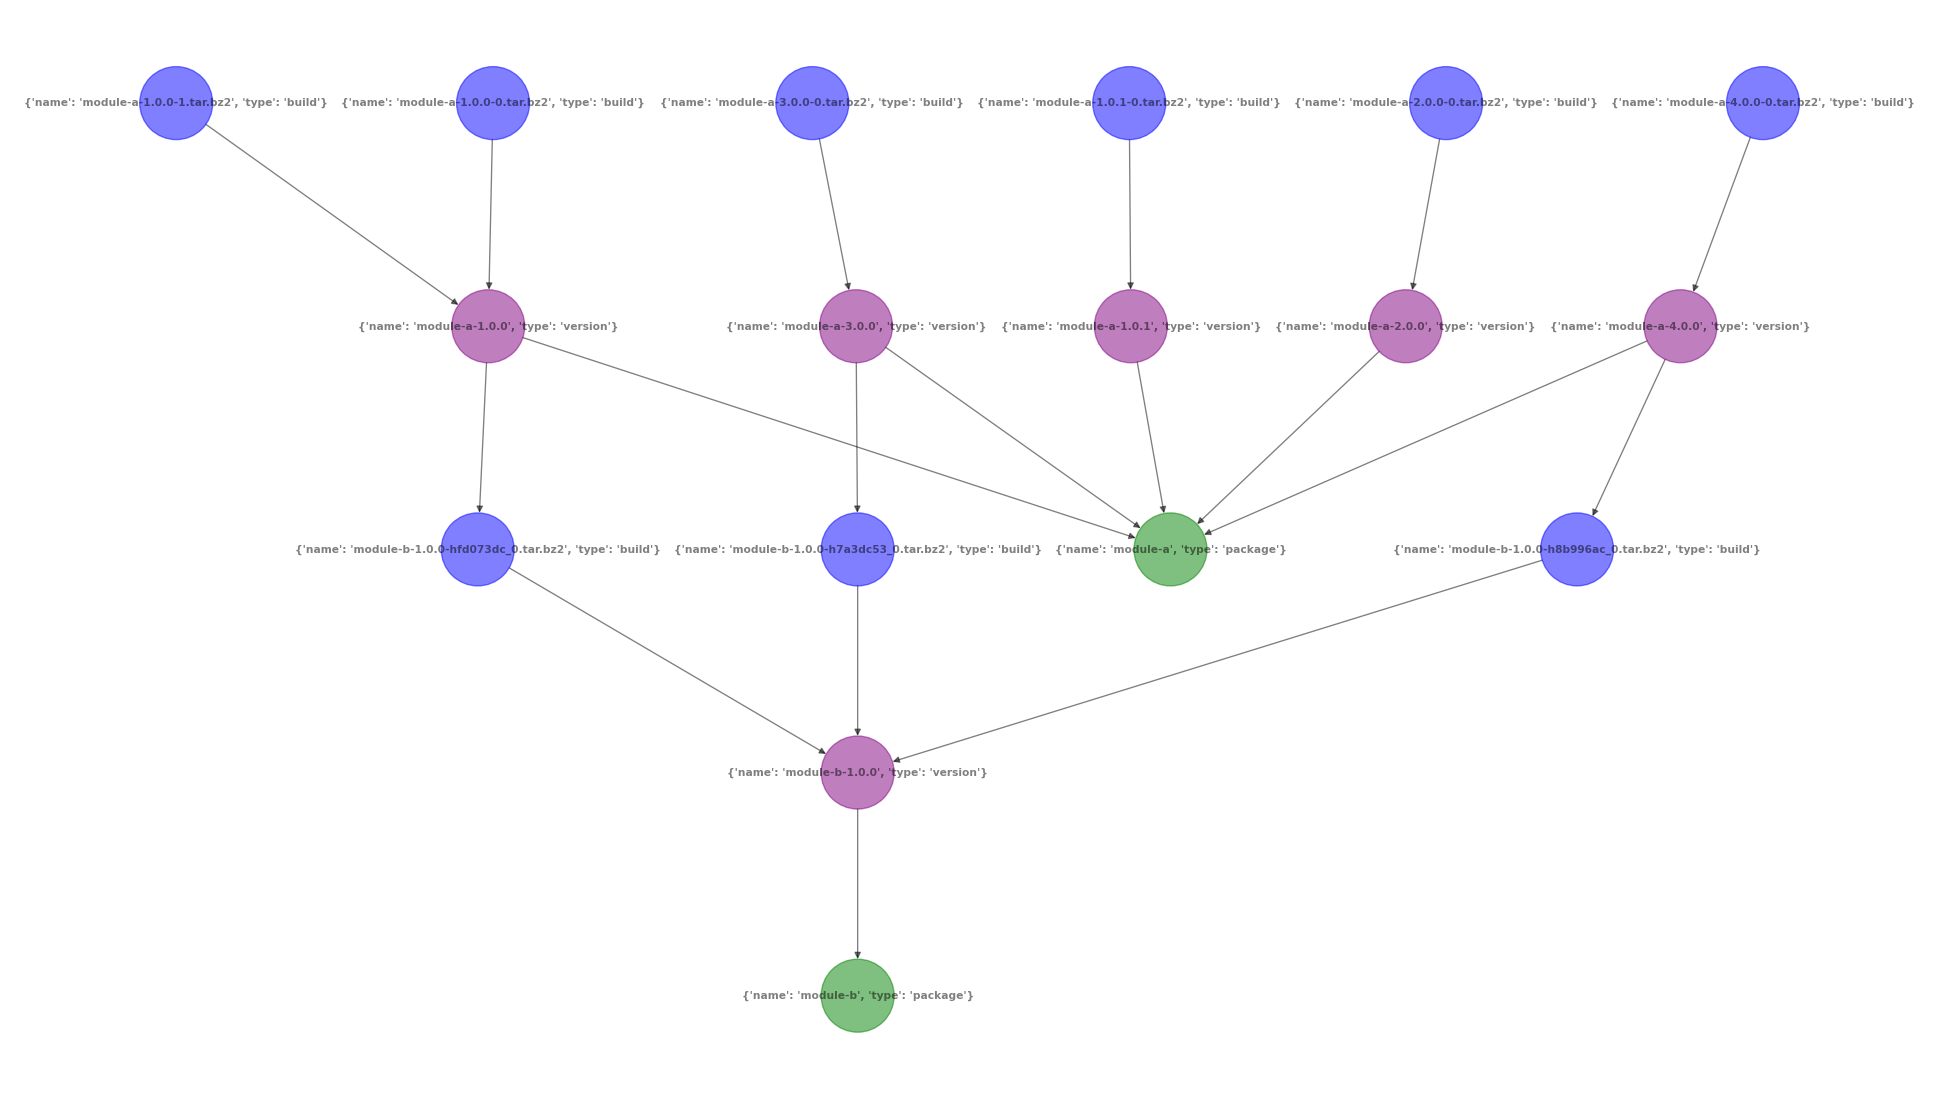

In [4]:
# Make a graph of package metadata from the conda channel
channel = "https://artifactory.esss.lu.se/artifactory/api/conda/conda-e3-test"
platform = "linux-64"
graph = make_metadata_graph(channel, platform)

# Get a subgraph with the packages of interest, their descendants, and their ancestors.
nodes_of_interest = [
    Package("module-a"), 
    Package("module-b")
]
subgraph = get_package_subgraph(graph, nodes_of_interest)

# Plot the subgraph
plt.figure(**figure_args)
nx.draw(subgraph, **graph_styling(subgraph))

In [9]:
# List all the nodes in the subgraph in alphabetical order
sorted(list(subgraph.nodes), key=lambda x: x["name"])

[{'name': 'module-a', 'type': 'package'},
 {'name': 'module-a-1.0.0', 'type': 'version'},
 {'name': 'module-a-1.0.0-0.tar.bz2', 'type': 'build'},
 {'name': 'module-a-1.0.0-1.tar.bz2', 'type': 'build'},
 {'name': 'module-a-1.0.1', 'type': 'version'},
 {'name': 'module-a-1.0.1-0.tar.bz2', 'type': 'build'},
 {'name': 'module-a-2.0.0', 'type': 'version'},
 {'name': 'module-a-2.0.0-0.tar.bz2', 'type': 'build'},
 {'name': 'module-a-3.0.0', 'type': 'version'},
 {'name': 'module-a-3.0.0-0.tar.bz2', 'type': 'build'},
 {'name': 'module-a-4.0.0', 'type': 'version'},
 {'name': 'module-a-4.0.0-0.tar.bz2', 'type': 'build'},
 {'name': 'module-b', 'type': 'package'},
 {'name': 'module-b-1.0.0', 'type': 'version'},
 {'name': 'module-b-1.0.0-h7a3dc53_0.tar.bz2', 'type': 'build'},
 {'name': 'module-b-1.0.0-h8b996ac_0.tar.bz2', 'type': 'build'},
 {'name': 'module-b-1.0.0-hfd073dc_0.tar.bz2', 'type': 'build'}]

In [10]:
# List all the edges in the subgraph in alphabetical order
sorted(list(subgraph.edges), key=lambda x: x[0]["name"])

[({'name': 'module-a-1.0.0', 'type': 'version'},
  {'name': 'module-a', 'type': 'package'}),
 ({'name': 'module-a-1.0.0', 'type': 'version'},
  {'name': 'module-b-1.0.0-hfd073dc_0.tar.bz2', 'type': 'build'}),
 ({'name': 'module-a-1.0.0-0.tar.bz2', 'type': 'build'},
  {'name': 'module-a-1.0.0', 'type': 'version'}),
 ({'name': 'module-a-1.0.0-1.tar.bz2', 'type': 'build'},
  {'name': 'module-a-1.0.0', 'type': 'version'}),
 ({'name': 'module-a-1.0.1', 'type': 'version'},
  {'name': 'module-a', 'type': 'package'}),
 ({'name': 'module-a-1.0.1-0.tar.bz2', 'type': 'build'},
  {'name': 'module-a-1.0.1', 'type': 'version'}),
 ({'name': 'module-a-2.0.0', 'type': 'version'},
  {'name': 'module-a', 'type': 'package'}),
 ({'name': 'module-a-2.0.0-0.tar.bz2', 'type': 'build'},
  {'name': 'module-a-2.0.0', 'type': 'version'}),
 ({'name': 'module-a-3.0.0', 'type': 'version'},
  {'name': 'module-a', 'type': 'package'}),
 ({'name': 'module-a-3.0.0', 'type': 'version'},
  {'name': 'module-b-1.0.0-h7a3dc53